低レベルのテンソル操作は TensorFlow API に置き換えられる

ディープラーニングの高レベルの概念はKeras API に置き換えられる


In [1]:
import tensorflow as tf

In [2]:
x = tf.ones(shape=(2, 1))
print(x)

x = tf.zeros(shape=(2, 1))
print(x)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


In [5]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(x)

x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)

tf.Tensor(
[[ 1.7727511 ]
 [-1.6989117 ]
 [ 0.98579854]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[0.88638866]
 [0.47654152]
 [0.6335156 ]], shape=(3, 1), dtype=float32)


## NumPy との違い
TensorFlowテンソルは定数であり、代入することはできない

そこで、変数（tf.Variable）を使う


In [7]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[ 0.18871385],
       [ 1.0423586 ],
       [-0.6760009 ]], dtype=float32)>


In [8]:
v.assign(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

In [9]:
v[0, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

In [10]:
v.assign_add(tf.ones((3, 1))) # assign_sub もある

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

In [11]:
# GradientTapeの入力として定数テンソルを使う
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
    tape.watch(input_const)
    result = tf.square(input_const)
gradient = tape.gradient(result, input_const)

## 線形分類器

In [12]:
import numpy as np

num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(mean=[0, 3],
                                                 cov=[[1, 0.5],[0.5, 1]],
                                                 size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(mean=[3, 0],
                                                 cov=[[1, 0.5],[0.5, 1]],
                                                 size=num_samples_per_class)

In [13]:
# 2つのクラスを１つの配列にまとめる
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

In [14]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

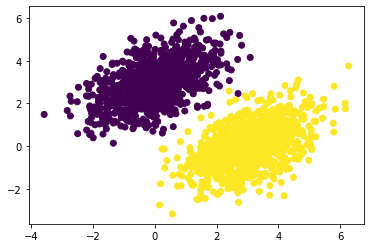

In [16]:
import matplotlib.pyplot as plt

plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

In [17]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim)))

In [18]:
def model(inputs):
    return tf.matmul(inputs, W) + b

In [19]:
def square_loss(targets, predictions):
    per_sample_loss = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_loss)

In [20]:
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(predictions, targets)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

In [21]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 2.3584
Loss at step 1: 0.4210
Loss at step 2: 0.1575
Loss at step 3: 0.1150
Loss at step 4: 0.1030
Loss at step 5: 0.0956
Loss at step 6: 0.0894
Loss at step 7: 0.0838
Loss at step 8: 0.0787
Loss at step 9: 0.0740
Loss at step 10: 0.0697
Loss at step 11: 0.0658
Loss at step 12: 0.0622
Loss at step 13: 0.0589
Loss at step 14: 0.0559
Loss at step 15: 0.0531
Loss at step 16: 0.0506
Loss at step 17: 0.0483
Loss at step 18: 0.0462
Loss at step 19: 0.0442
Loss at step 20: 0.0425
Loss at step 21: 0.0408
Loss at step 22: 0.0394
Loss at step 23: 0.0380
Loss at step 24: 0.0368
Loss at step 25: 0.0356
Loss at step 26: 0.0346
Loss at step 27: 0.0337
Loss at step 28: 0.0328
Loss at step 29: 0.0320
Loss at step 30: 0.0313
Loss at step 31: 0.0306
Loss at step 32: 0.0300
Loss at step 33: 0.0294
Loss at step 34: 0.0289
Loss at step 35: 0.0285
Loss at step 36: 0.0280
Loss at step 37: 0.0276
Loss at step 38: 0.0273
Loss at step 39: 0.0270


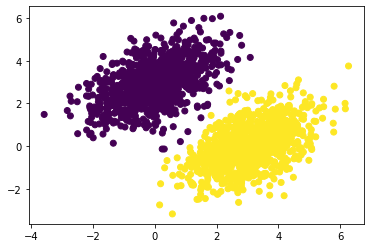

In [22]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

## Layerクラス：Kerasのベースクラス
単純なAPIでは、全ての中心に１つの単純な抽象化があるはず。KerasにおいてそれにあたるのはLayerクラス。

Layerは状態（重み）と計算（フォワードパス）をカプセル化したオブジェクト。

重みは一般に build メソッドで定義され、計算は call メソッドで定義される

In [24]:
from tensorflow import keras

class SimpleDense(keras.layers.Layer):
    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.units),
                                 initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros")
        
    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

In [25]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu)

input_tensor = tf.ones(shape=(2, 784))

output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 32)


In [28]:
"""
ベースクラスの __call__ には次のような実装が入っている

def __call__(self, inputs):
    if not self.build:
        self.build(inputs.shape)
        self.built = true
    return self.call(inputs)

そのため、カスタム層を実装する時には、「フォワードパスは call() で定義する」だけで良い
"""

'\nベースクラスの __call__ には次のような実装が入っている\n\ndef __call__(self, inputs):\n    if not self.build:\n        self.build(inputs.shape)\n        self.built = true\n    return self.call(inputs)\n'

## Model
モデルを作成する方法は主に２つあり、Modelクラスをサブクラス化する方法と、Functional API を使う方法